# QOSF Task 2 — Complex Amplitudes
# (two-qubits and three-qubits states)

This notebook demonstrates a **quantum framework-agnostic** routine to prepare quantum states from complex amplitudes **without** high-level initializers.

**Contents**
1. Method overview (Householder reflection)
2. 2-qubit demo (end-to-end)
3. 3-qubit demo (end-to-end)
4. Validation (unitarity, global-phase alignment)
5. Experiment (brief)
6. Gotchas & next steps

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

from state_prep import (
    normalize_amplitudes,
    state_vector_from_amplitudes,
    householder_unitary_for_state,
    prepare_state_unitary,
    apply_unitary_to_zero,
    global_phase_align,
)

np.set_printoptions(precision=4, suppress=True)

## 1. Method overview

Given a **normalized** target state vector \( \psi \in \mathbb{C}^{2^n} \), we seek a unitary \( U \) such that \( U\,e_1 = \psi \), where \( e_1 = [1,0,\dots,0]^T \) encodes \(|0\ldots 0\rangle\).

We use a (complex) **Householder reflection**:

\[
v = \frac{e_1 - \psi}{\|e_1 - \psi\|}, \qquad H = I - 2\, v v^\dagger.
\]

Then \( H e_1 = \psi \). If \( \psi \approx e_1 \), we fallback to \( I \) for numerical stability.

## 2. 2-qubit demo (4 amplitudes)

End-to-end path: amplitudes → normalized state \(\psi\) → unitary \(U\) → check that \(U|00\rangle = \psi\) up to a global phase.


||psi2|| = 1.0
unitarity ||U†U - I||_F = 5.16003696509565e-16
state match (up to global phase): True
max |diff| (magnitudes): 0.0
||psi2 - out_aligned||_2: 7.97218214573518e-17


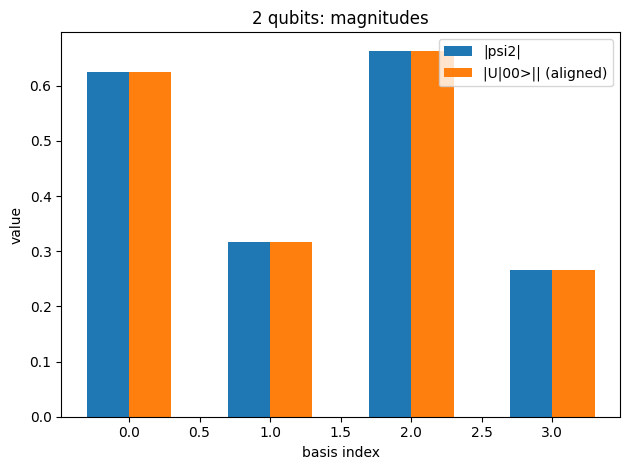

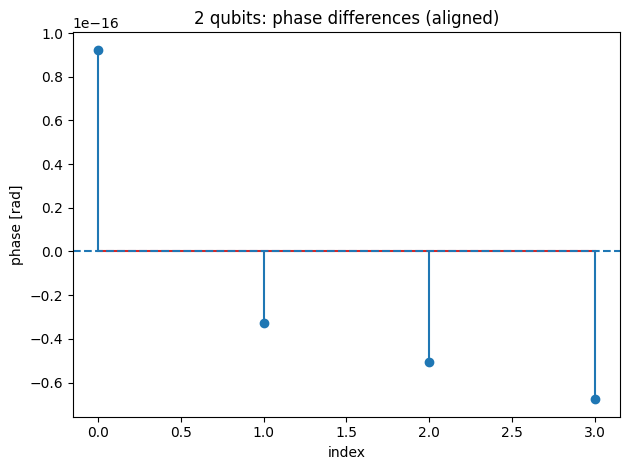

In [2]:
rng = np.random.default_rng(123)
a2 = rng.normal(size=4) + 1j * rng.normal(size=4)
psi2, U2 = prepare_state_unitary(a2)
out2 = apply_unitary_to_zero(U2)
print("||psi2|| =", la.norm(psi2))
print("unitarity ||U†U - I||_F =", la.norm(U2.conj().T @ U2 - np.eye(4)))

out_aligned, phase2 = global_phase_align(psi2, out2)
print("state match (up to global phase):", np.allclose(psi2, out_aligned, atol=1e-10))
print("max |diff| (magnitudes):", np.max(np.abs(np.abs(psi2) - np.abs(out_aligned))))
print("||psi2 - out_aligned||_2:", la.norm(psi2 - out_aligned))

# Magnitudes
mag_target = np.abs(psi2)
mag_obtained = np.abs(out_aligned)

plt.figure()
plt.bar(np.arange(4)-0.15, mag_target, width=0.3, label='|psi2|')
plt.bar(np.arange(4)+0.15, mag_obtained, width=0.3, label='|U|00>|| (aligned)')
plt.legend(); plt.title('2 qubits: magnitudes'); plt.xlabel('basis index'); plt.ylabel('value')
plt.tight_layout(); plt.show()

# Phase differences wrapped to [-pi, pi]
phase_diff = np.angle(psi2 * np.conj(out_aligned))

plt.figure()
markerline, stemlines, baseline = plt.stem(phase_diff)
plt.title('2 qubits: phase differences (aligned)')
plt.xlabel('index'); plt.ylabel('phase [rad]')
plt.axhline(0, linestyle='--')
plt.tight_layout(); plt.show()


## 3. 3-qubit demo (8 amplitudes)

Same workflow as for 2 qubits, but with 8 complex amplitudes.

||psi3|| = 0.9999999999999999
unitarity ||U†U - I||_F = 6.527631776364416e-16
state match (up to global phase): True


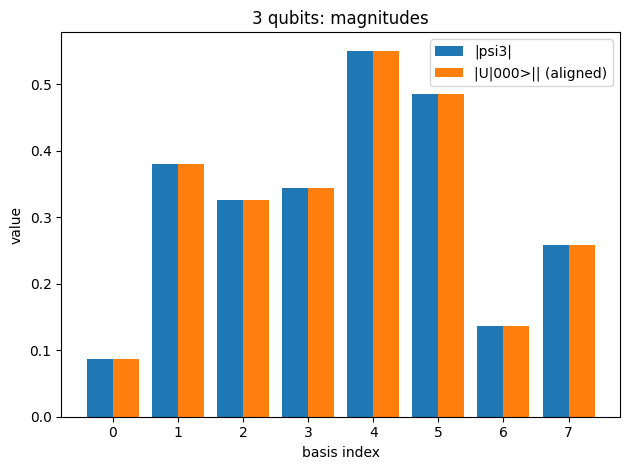

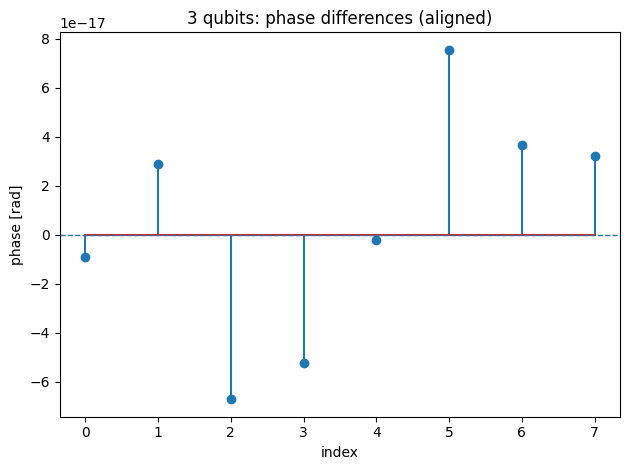

In [3]:
rng = np.random.default_rng(42)
a3 = rng.normal(size=8) + 1j * rng.normal(size=8)
psi3, U3 = prepare_state_unitary(a3)
out3 = apply_unitary_to_zero(U3)
out3_aligned, phase3 = global_phase_align(psi3, out3)

print("||psi3|| =", la.norm(psi3))
print("unitarity ||U†U - I||_F =", la.norm(U3.conj().T @ U3 - np.eye(8)))
print("state match (up to global phase):", np.allclose(psi3, out3_aligned, atol=1e-10))

# Magnitudes
mag_t = np.abs(psi3)
mag_o = np.abs(out3_aligned)
plt.figure()
plt.bar(np.arange(8)-0.2, mag_t, width=0.4, label='|psi3|')
plt.bar(np.arange(8)+0.2, mag_o, width=0.4, label='|U|000>|| (aligned)')
plt.legend(); plt.title('3 qubits: magnitudes'); plt.xlabel('basis index'); plt.ylabel('value')
plt.tight_layout(); plt.show()

# Phase diffs in [-pi, pi]
phase_diff3 = np.angle(psi3 * np.conj(out3_aligned))
plt.figure()
plt.stem(phase_diff3)
plt.axhline(0, linestyle='--', linewidth=1)
plt.title('3 qubits: phase differences (aligned)')
plt.xlabel('index'); plt.ylabel('phase [rad]')
plt.tight_layout(); plt.show()

2q: median unitary err = 5.28e-16, median state err = 2.41e-16


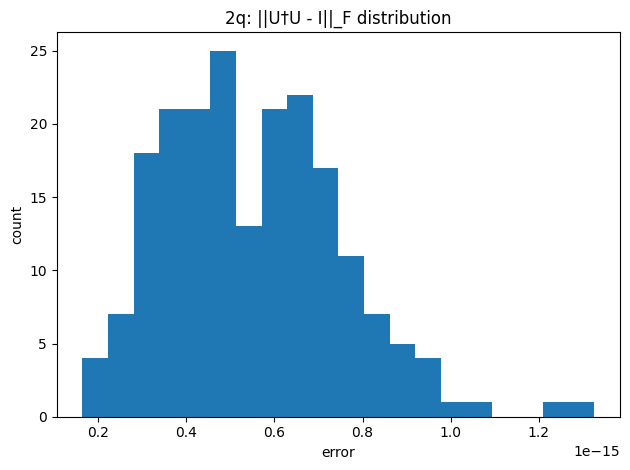

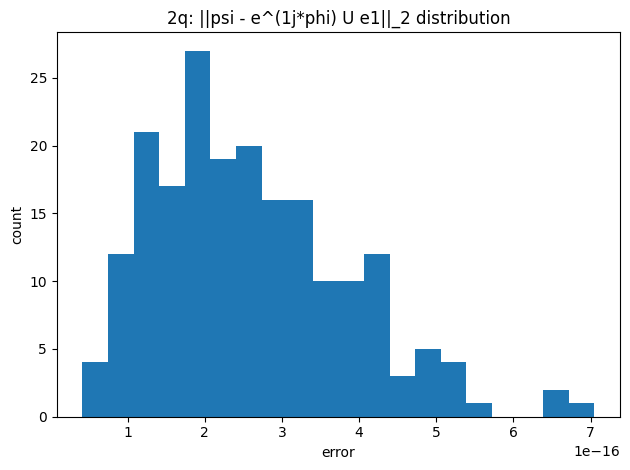

3q: median unitary err = 6.71e-16, median state err = 2.35e-16


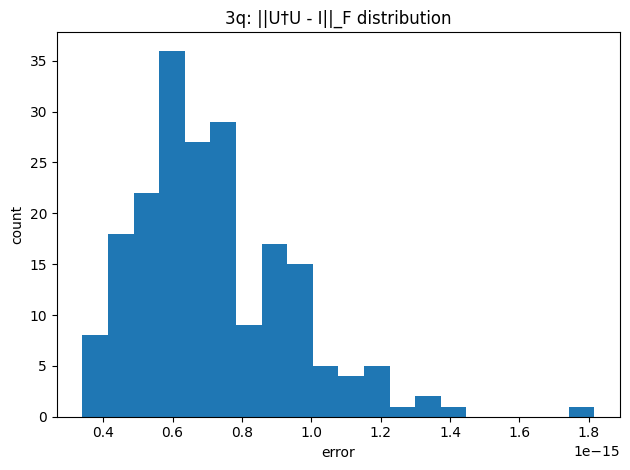

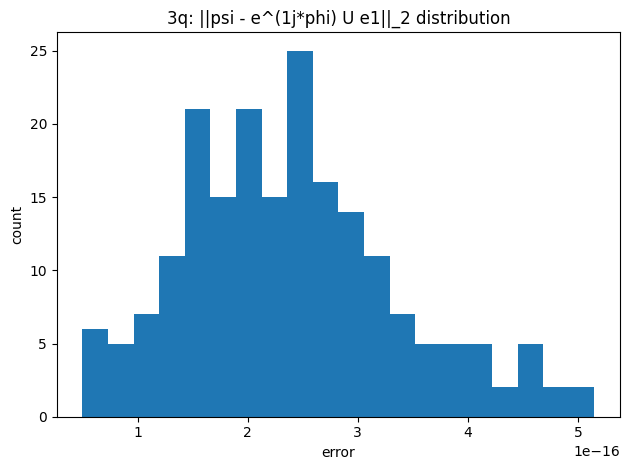

In [5]:
def mc_errors(dim=4, trials=200, seed=1):
    rng = np.random.default_rng(seed)
    unit_err = []
    state_err = []
    for _ in range(trials):
        a = rng.normal(size=dim) + 1j*rng.normal(size=dim)
        psi, U = prepare_state_unitary(a)
        out = apply_unitary_to_zero(U)
        out_aligned, _ = global_phase_align(psi, out)
        unit_err.append(la.norm(U.conj().T @ U - np.eye(dim)))
        state_err.append(la.norm(psi - out_aligned))
    return np.array(unit_err), np.array(state_err)

for dim, label in [(4, "2q"), (8, "3q")]:
    ue, se = mc_errors(dim=dim, trials=200, seed=123)
    print(f"{label}: median unitary err = {np.median(ue):.2e}, median state err = {np.median(se):.2e}")
    plt.figure()
    plt.hist(ue, bins=20)
    plt.title(f"{label}: ||U†U - I||_F distribution")
    plt.xlabel("error"); plt.ylabel("count"); plt.tight_layout(); plt.show()

    plt.figure()
    plt.hist(se, bins=20)
    plt.title(f"{label}: ||psi - e^(1j*phi) U e1||_2 distribution")
    plt.xlabel("error"); plt.ylabel("count"); plt.tight_layout(); plt.show()
